# Desarrollo discriminador PatchGAN
Notebook de desarrollo y pruebas del discriminador

### Preparar ambiente

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


In [4]:
from discriminador import (
    PatchGANDiscriminator,
    DiscriminatorLoss,
    init_discriminator_weights,
    RECOMMENDED_CONFIG
)

print("Módulo importado correctamente")
print(f"Configuración recomendada: {RECOMMENDED_CONFIG}")

Módulo importado correctamente
Configuración recomendada: {'input_channels': 3, 'features': 64, 'learning_rate': 0.0002, 'betas': (0.5, 0.999), 'real_label': 0.9, 'fake_label': 0.0, 'gradient_clip': 1.0}


### Crear y probar discriminador

In [5]:
# Crear discriminador
discriminator = PatchGANDiscriminator(
    input_channels=3,
    features=64
).to(device)

# Inicializar pesos
init_discriminator_weights(discriminator)

# Info del modelo
print(f"Discriminador creado")
print(f"   Parámetros: {discriminator.get_num_params():,}")
print(f"   Device: {next(discriminator.parameters()).device}")

Discriminador creado
   Parámetros: 2,765,633
   Device: cpu


### Pruebas con datos sintéticos

In [6]:
# Crear batch de prueba
batch_size = 8
test_lab = torch.randn(batch_size, 3, 128, 128).to(device)

# Forward pass
with torch.no_grad():
    output = discriminator(test_lab)

print(f"Forward pass exitoso")
print(f"   Input:  {tuple(test_lab.shape)}")
print(f"   Output: {tuple(output.shape)}")
print(f"   Output range: [{output.min():.3f}, {output.max():.3f}]")

Forward pass exitoso
   Input:  (8, 3, 128, 128)
   Output: (8, 1, 14, 14)
   Output range: [-3.544, 5.172]


In [7]:
## Test Función de Pérdida

criterion = DiscriminatorLoss(
    real_label=RECOMMENDED_CONFIG['real_label'],
    fake_label=RECOMMENDED_CONFIG['fake_label']
)

# Simular predicciones
real_pred = torch.randn(batch_size, 1, 14, 14).to(device)
fake_pred = torch.randn(batch_size, 1, 14, 14).to(device)

# Calcular pérdida
loss, real_loss, fake_loss, real_acc, fake_acc = criterion(real_pred, fake_pred)

print(f"Función de pérdida funcionando")
print(f"   Loss total:    {loss.item():.4f}")
print(f"   Loss real:     {real_loss.item():.4f}")
print(f"   Loss fake:     {fake_loss.item():.4f}")
print(f"   Accuracy real: {real_acc*100:.1f}%")
print(f"   Accuracy fake: {fake_acc*100:.1f}%")
print(f"   Accuracy avg:  {((real_acc + fake_acc)/2)*100:.1f}%")


Función de pérdida funcionando
   Loss total:    0.8218
   Loss real:     0.7988
   Loss fake:     0.8449
   Accuracy real: 51.6%
   Accuracy fake: 46.4%
   Accuracy avg:  49.0%


### Visualización de arquitectura

In [8]:
# Visualización de dimensiones
discriminator.eval()
x = torch.randn(1, 3, 128, 128).to(device)

print("FLUJO DE DIMENSIONES")
print(f"Input (LAB):   {tuple(x.shape)}")

with torch.no_grad():
    x1 = discriminator.layer1(x)
    print(f"Layer 1:       {tuple(x1.shape)}")

    x2 = discriminator.layer2(x1)
    print(f"Layer 2:       {tuple(x2.shape)}")

    x3 = discriminator.layer3(x2)
    print(f"Layer 3:       {tuple(x3.shape)}")

    x4 = discriminator.layer4(x3)
    print(f"Layer 4:       {tuple(x4.shape)}")

    out = discriminator.output_layer(x4)
    print(f"Output:        {tuple(out.shape)}")

print(f"Receptive field: ~34x34 píxeles por patch")
print(f"Total patches: {14*14} = 196")

FLUJO DE DIMENSIONES
Input (LAB):   (1, 3, 128, 128)
Layer 1:       (1, 64, 64, 64)
Layer 2:       (1, 128, 32, 32)
Layer 3:       (1, 256, 16, 16)
Layer 4:       (1, 512, 15, 15)
Output:        (1, 1, 14, 14)
Receptive field: ~34x34 píxeles por patch
Total patches: 196 = 196


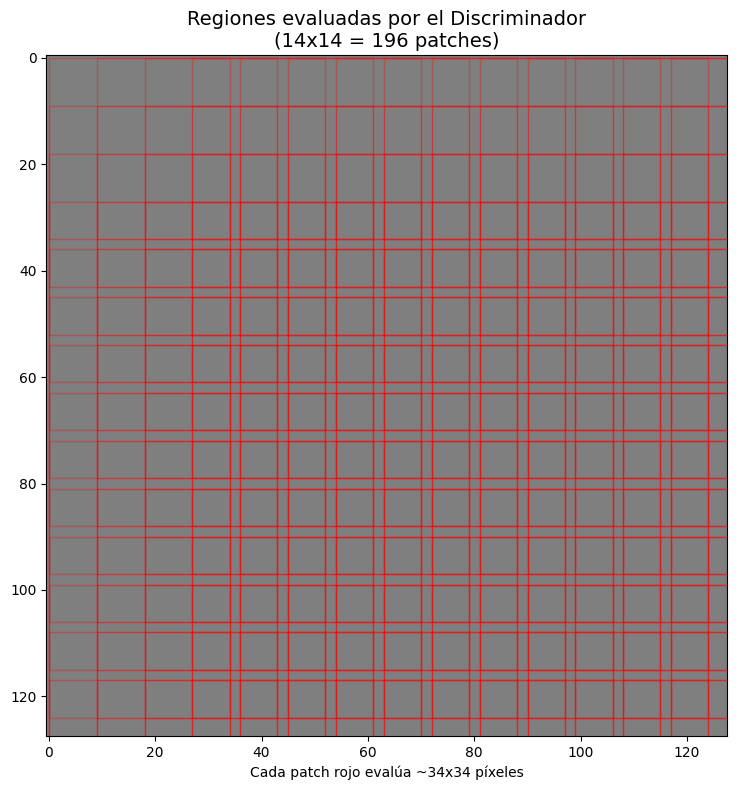

In [9]:
# Visualización de Patches Evaluados
# Muestra qué regiones evalúa cada patch del discriminador
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Crear imagen de ejemplo
img = np.ones((128, 128, 3)) * 0.5

# Tamaño aproximado de cada patch
patch_size = 34
stride = 128 // 14  # Aproximadamente 9 píxeles

# Dibujar grid de patches
for i in range(14):
    for j in range(14):
        y = i * stride
        x = j * stride

        # Dibujar rectángulo
        rect = plt.Rectangle((x, y), patch_size, patch_size,
                            linewidth=1, edgecolor='red',
                            facecolor='none', alpha=0.3)
        ax.add_patch(rect)

ax.imshow(img)
ax.set_title('Regiones evaluadas por el Discriminador\n(14x14 = 196 patches)', fontsize=14)
ax.set_xlabel('Cada patch rojo evalúa ~34x34 píxeles')
ax.grid(False)
plt.tight_layout()
plt.show()


### Simulación de entrenamiento

In [10]:
## Simulación de Training Step
#Simula un paso de entrenamiento del discriminador

discriminator.train()
optimizer = torch.optim.Adam(
    discriminator.parameters(),
    lr=RECOMMENDED_CONFIG['learning_rate'],
    betas=RECOMMENDED_CONFIG['betas']
)

# Datos simulados
real_lab = torch.randn(4, 3, 128, 128).to(device)
fake_lab = torch.randn(4, 3, 128, 128).to(device)

# Forward
optimizer.zero_grad()
real_pred = discriminator(real_lab)
fake_pred = discriminator(fake_lab)

# Loss
loss, real_loss, fake_loss, real_acc, fake_acc = criterion(real_pred, fake_pred)

# Backward
loss.backward()

# Gradient clipping
torch.nn.utils.clip_grad_norm_(
    discriminator.parameters(),
    max_norm=RECOMMENDED_CONFIG['gradient_clip']
)

optimizer.step()

print(f"Training step simulado")
print(f"   Loss: {loss.item():.4f}")
print(f"   Gradientes clippeados a {RECOMMENDED_CONFIG['gradient_clip']}")
print(f"   Accuracy: {((real_acc + fake_acc)/2)*100:.1f}%")

Training step simulado
   Loss: 0.8892
   Gradientes clippeados a 1.0
   Accuracy: 51.3%


In [11]:
print("RESUMEN DEL DISCRIMINADOR")
print(f"Arquitectura: PatchGAN para 128x128")
print(f"Output: 14x14 patches")
print(f"Parámetros: {discriminator.get_num_params():,}")
print(f"Receptive field: ~34x34 píxeles")
print(f"Pérdida: BCEWithLogitsLoss con label smoothing")
print(f"Configuración: {RECOMMENDED_CONFIG}")

RESUMEN DEL DISCRIMINADOR
Arquitectura: PatchGAN para 128x128
Output: 14x14 patches
Parámetros: 2,765,633
Receptive field: ~34x34 píxeles
Pérdida: BCEWithLogitsLoss con label smoothing
Configuración: {'input_channels': 3, 'features': 64, 'learning_rate': 0.0002, 'betas': (0.5, 0.999), 'real_label': 0.9, 'fake_label': 0.0, 'gradient_clip': 1.0}
